# Libraries

In [ ]:
# 必要なライブラリのインポート
import pandas as pd          # データフレーム操作のためのライブラリ
import polars as pl          # 高速データフレーム処理ライブラリ
import numpy as np           # 数値計算ライブラリ
import matplotlib.pyplot as plt  # データ可視化ライブラリ
# モデリング関連のライブラリ
import lightgbm as lgb       # 勾配ブースティングモデル実装
from sklearn.model_selection import KFold  # 交差検証用のデータ分割ツール
from sklearn.metrics import mean_squared_error  # 評価指標（平均二乗誤差）
from preprocessings import pipe_line  # 前処理用のカスタムパイプライン関数

# Configuration

In [2]:
# 入力データファイルのパス設定
TRAIN_PATH = '/Users/aria/Kaggle/real_estate/dataset/train.csv'  # 訓練データのファイルパス
TEST_PATH = '/Users/aria/Kaggle/real_estate/dataset/test.csv'    # テストデータのファイルパス
SUB_PATH = '/Users/aria/Kaggle/real_estate/dataset/sample_submit.csv'  # 提出用サンプルファイルのパス

# Preprocessing

In [3]:
# データの読み込みと基本情報の確認
train = pl.read_csv(TRAIN_PATH)  # 訓練データをPolarsデータフレームとして読み込み
test = pl.read_csv(TEST_PATH)    # テストデータをPolarsデータフレームとして読み込み
print(train.shape, test.shape)   # 訓練データとテストデータの形状（行数×列数）を出力
train.head()                     # 訓練データの先頭数行を表示して内容を確認

(31470, 17) (31262, 16)


id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
1,75000,"""東京都北区滝野川３丁目""","""都営三田線 西巣鴨駅 徒歩4…","""1K""","""9年9ヶ月""","""南東""","""20.01m2""","""1階／12階建""","""専用バス／ 専用トイレ／ バ…","""ガスコンロ／ コンロ2口／ …","""インターネット対応／ CAT…","""エアコン付 シューズボックス…","""駐輪場 空有""","""【小学校】 495m 【大学…","""RC（鉄筋コンクリート）""","""2年間"""
2,76000,"""東京都中央区月島３丁目""","""都営大江戸線 勝どき駅 徒歩…","""1R""","""44年10ヶ月""",null,"""16.5m2""","""5階／10階建""","""専用トイレ／ シャワー／ 温…","""ガスコンロ／ システムキッチ…","""インターネット対応""","""エアコン付 シューズボックス…","""駐輪場 空有 駐車場 無 バ…","""【スーパー】 1283m""","""鉄骨造""","""2年間"""
3,110000,"""東京都渋谷区笹塚２丁目""","""京王線 笹塚駅 徒歩6分 …","""1K""","""8年6ヶ月""","""南""","""22.05m2""","""12階／15階建""","""専用バス／ 専用トイレ／ バ…","""ガスコンロ／ コンロ2口／ …","""インターネット対応／ 光ファ…","""エアコン付 ウォークインクロ…","""駐輪場 空有 バイク置き場 …","""【スーパー】 89m 【コン…","""RC（鉄筋コンクリート）""","""2年間"""
4,150000,"""東京都杉並区高円寺南２丁目2…","""総武線・中央線（各停） 高円…","""2LDK""","""29年4ヶ月""","""南""","""60.48m2""","""3階／4階建""","""専用バス／ 専用トイレ／ バ…","""ガスコンロ／ 給湯""","""インターネット対応／ 光ファ…","""エアコン付 シューズボックス…","""駐車場 無 駐輪場 無 バイ…","""【スーパー】 225m 【ス…","""RC（鉄筋コンクリート）""","""2年間 ※この物件は 定期借…"
5,74000,"""東京都葛飾区金町３丁目7-2…","""京成金町線 京成金町駅 徒歩…","""2DK""","""31年7ヶ月""","""南""","""39.66m2""","""1階／2階建""","""専用バス／ 専用トイレ／ バ…","""給湯／ 独立キッチン""",null,"""バルコニー／ フローリング／…","""駐車場 近隣 17,000円…","""【スーパー】 193m 【ス…","""木造""","""2年間"""


In [4]:
# パイプラインを使用して前処理を適用
train, test, cat_cols = pipe_line(train, test)  # 訓練データとテストデータに前処理を適用
print(train.shape)  # 前処理後の訓練データの形状を出力
train  # 前処理後の訓練データを表示して確認

(46548, 73)


,id,Target,Direction,Area,district,is_toshin,latitude,longitude,Land_Price,min_time_to_alive,...,super_distance,cs_distance,count_buildings,rank_of_material,is_temporal,term,is_vintage,Unit_Target,Minato_ward_Potential,Chuou_ward_Potential
0,1,75000.0,南東,20.01,北,0,35.748593,139.728979,5.322000e+05,4.0,...,311.0,588.0,10.0,2,0,24.0,0,3748.125937,107.079959,123.970708
1,2,76000.0,missing,16.50,中央,1,35.662900,139.779212,1.496879e+06,5.0,...,1283.0,NaN,1.0,6,0,24.0,0,4606.060606,594.266780,7162.971991
2,3,110000.0,南,22.05,渋谷,1,35.675148,139.667012,4.053853e+06,6.0,...,89.0,184.0,4.0,2,0,24.0,0,4988.662132,173.333095,78.311299
3,4,150000.0,南,60.48,杉並,0,35.700200,139.651335,5.302020e+05,3.0,...,225.0,326.0,6.0,2,1,24.0,0,2480.158730,99.510027,58.109125
4,5,74000.0,南,39.66,葛飾,0,35.766807,139.875451,3.285000e+05,5.0,...,193.0,351.0,5.0,8,0,24.0,0,1865.859808,31.710537,56.837013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63040,55696,285500.0,東,52.20,新宿,1,35.706239,139.742185,1.049591e+06,4.0,...,255.0,131.0,4.0,2,0,24.0,0,5469.348659,345.841925,412.126311
63042,39026,107000.0,南,42.86,足立,0,35.795687,139.796115,4.426469e+05,12.0,...,152.0,274.0,5.0,7,0,24.0,0,2496.500233,42.201269,67.114367
63046,49810,470000.0,西,89.59,新宿,1,35.695364,139.709795,1.049591e+06,2.0,...,500.0,196.0,4.0,2,1,24.0,0,5246.121219,367.880417,186.632593
63049,56098,102000.0,南,55.00,足立,0,35.785898,139.818488,4.426469e+05,3.0,...,NaN,NaN,NaN,6,0,24.0,0,1854.545455,41.628590,72.213216


In [5]:
test # 前処理後の訓練データを表示して確認

,id,Target,Direction,Area,district,is_toshin,latitude,longitude,Land_Price,min_time_to_alive,...,super_distance,cs_distance,count_buildings,rank_of_material,is_temporal,term,is_vintage,Unit_Target,Minato_ward_Potential,Chuou_ward_Potential
31791,56015,NaN,南,39.75,品川,0,35.614080,139.738630,9.527392e+05,6.0,...,541.0,326.0,9.0,2,0,24.0,0,NaN,675.959352,185.667852
31792,38410,NaN,東,40.00,江戸川,0,35.710151,139.877726,3.821637e+05,2.0,...,NaN,NaN,7.0,8,0,24.0,0,NaN,44.602791,92.546874
31793,35534,79000.0,東,23.69,江東,0,35.687179,139.823428,6.032431e+05,5.0,...,850.0,1031.0,5.0,7,0,24.0,0,3334.740397,121.351471,489.995203
31794,46425,NaN,missing,26.66,杉並,0,35.691411,139.663336,5.302020e+05,2.0,...,NaN,NaN,9.0,2,0,24.0,0,NaN,136.688004,71.977212
31795,57590,NaN,南,20.30,北,0,35.766959,139.727804,5.417897e+05,5.0,...,188.0,73.0,5.0,6,0,24.0,0,NaN,75.581313,88.970267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63048,56080,NaN,東,25.00,杉並,0,35.695655,139.607625,5.302020e+05,14.0,...,NaN,NaN,NaN,8,0,NaN,0,NaN,51.930488,33.159363
63049,56098,102000.0,南,55.00,足立,0,35.785898,139.818488,4.426469e+05,3.0,...,NaN,NaN,NaN,6,0,24.0,0,1854.545455,41.628590,72.213216
63050,46624,NaN,北西,30.98,港,1,35.674826,139.733574,3.562081e+06,5.0,...,NaN,NaN,NaN,2,0,NaN,0,NaN,1878.315891,463.683021
63051,55038,NaN,南,64.00,葛飾,0,35.752888,139.848292,3.283643e+05,11.0,...,891.0,581.0,2.0,2,0,24.0,0,NaN,45.657793,92.788959


In [6]:
# テストデータ内の目的変数が欠損していないデータの割合を計算
len(test[test.Target.notna()])/len(test)  # 欠損値でないTarget列データの割合を算出

0.47204273558953364

# Modeling

In [7]:
# LightGBM モデルのハイパーパラメータ設定
params = {
   'objective': 'regression',        # 回帰問題として定義
   'metric': 'rmse',                 # 評価指標：二乗平均平方根誤差
   'boosting_type': 'gbdt',          # 勾配ブースティング決定木
   'learning_rate': 0.05,            # 学習率
   'num_leaves': 31,                 # 一つの木における最大葉の数
   'max_depth': -1,                  # 最大深さ（-1は無制限）
   'min_child_samples': 20,          # 各葉に必要な最小サンプル数
   'max_bin': 512,                   # ヒストグラムのビン数（255から増加してカテゴリ処理向上）
   'subsample': 0.85,                # サンプリング率
   'subsample_freq': 10,             # サブサンプリングの頻度
   'colsample_bytree': 0.8,          # 各木の構築に使用する特徴量の割合
   'min_child_weight': 0.001,        # 葉ノードのサンプル重みの最小合計値
   'subsample_for_bin': 200000,      # ビン計算用のサブサンプリングサイズ
   'min_split_gain': 0,              # 分割に必要な最小ゲイン
   'reg_alpha': 0,                   # L1正則化項
   'reg_lambda': 0,                  # L2正則化項
   'force_row_wise': True,           # 行単位の計算を明示的に設定
}

In [8]:
# モデルの保存用リスト
common_price_models = []    # 一般価格帯のモデルを保存するリスト
high_price_models = []      # 高価格帯のモデルを保存するリスト

# 一般価格帯モデルのトレーニング（賃料が300,000円以下のデータ）
## 5分割交差検証を使用
X = train[train.Target <= 300000].drop(['id', 'Target','Unit_Target'], axis=1)  # 説明変数の抽出（IDと目的変数を除外）
y = train[train.Target <= 300000].Target                  # 目的変数（賃料）
y_unit = train[train.Target <= 300000].Unit_Target        # 単位面積あたりの目的変数（単位賃料）
X.reset_index(drop=True, inplace=True)                    # インデックスのリセット
y.reset_index(drop=True, inplace=True)                    # インデックスのリセット
y_unit.reset_index(drop=True, inplace=True)               # インデックスのリセット
print(X.shape)                                            # データセットのサイズを確認

## K分割交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)     # 5分割交差検証（シャッフル有り、乱数シード42）

# 各分割でのMSE（平均二乗誤差）を格納するリスト
mse_scores = []
mse_scores_2 = []

# 5分割交差検証の実行
for train_index, test_index in kf.split(X):
    # 訓練データとテストデータの分割
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_unit_test, y_test = y_unit.iloc[train_index], y_unit.iloc[test_index], y.iloc[test_index]
    
    # LightGBM用のデータセット作成
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
    lgb_eval = lgb.Dataset(X_test, y_unit_test, reference=lgb_train)
    
    # モデルの訓練
    model = lgb.train(params,
                    lgb_train,
                    num_boost_round=20000,                           # 最大イテレーション数
                    valid_sets=[lgb_eval],                           # 検証用データセット
                    callbacks=[lgb.early_stopping(stopping_rounds=100)]  # 早期停止（100回改善がなければ停止）
                )
    common_price_models.append(model)                               # 訓練済みモデルをリストに追加
    
    # テストデータに対する予測
    # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    # 単位面積当たり予測値に面積を掛けて実際の賃料予測値に変換
    y_pred = model.predict(X_test, num_iteration=model.best_iteration) * X_test.Area.to_numpy()
    
    ## MSEを計算してリストに追加
    mse = np.sqrt(mean_squared_error(y_test, y_pred))               # RMSE（二乗平均平方根誤差）の計算
    mse_scores.append(mse)

# 全分割の平均MSEを出力
print("Average MSE across the folds:", np.mean(mse_scores))
print("\n\n")

# 高価格帯モデルのトレーニング（賃料が100,000円以上のデータ）
## 5分割交差検証を使用
X = train[train.Target >= 100000].drop(['id', 'Target', 'Unit_Target'], axis=1)  # 説明変数の抽出
y = train[train.Target >=100000]['Target']                # 目的変数（賃料）
y_unit = train[train.Target >=100000]['Unit_Target']      # 単位面積あたりの目的変数
X.reset_index(drop=True, inplace=True)                    # インデックスのリセット
y.reset_index(drop=True, inplace=True)                    # インデックスのリセット
y_unit.reset_index(drop=True, inplace=True)               # インデックスのリセット
print(X.shape)                                            # データセットのサイズを確認

## K分割交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)     # 5分割交差検証

# 各分割でのMSEを格納するリスト
mse_scores = []

# 5分割交差検証の実行
for train_index, test_index in kf.split(X):
    # 訓練データとテストデータの分割
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train, y_unit_test, y_test = y_unit.iloc[train_index], y_unit.iloc[test_index], y.iloc[test_index]
    
    # LightGBM用のデータセット作成
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
    #lgb_eval = lgb.Dataset(X_test, y_test, categorical_feature=cat_cols, reference=lgb_train)
    lgb_eval = lgb.Dataset(X_test, y_unit_test, categorical_feature=cat_cols, reference=lgb_train)
    
    # モデルの訓練
    model = lgb.train(params,
                    lgb_train,
                    num_boost_round=20000,                           # 最大イテレーション数
                    valid_sets=[lgb_eval],                           # 検証用データセット
                    callbacks=[lgb.early_stopping(stopping_rounds=100)]  # 早期停止
                )
    high_price_models.append(model)                                  # 訓練済みモデルをリストに追加
    
    # テストデータに対する予測
    y_pred = model.predict(X_test, num_iteration=model.best_iteration) * X_test.Area  # 単位面積当たり予測に面積を掛ける
    
    # MSEを計算してリストに追加
    mse = np.sqrt(mean_squared_error(y_test, y_pred))               # RMSE（二乗平均平方根誤差）の計算
    mse_scores.append(mse)

# 全分割の平均MSEを出力
print("Average MSE across the folds:", np.mean(mse_scores))

(45669, 70)
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 36535, number of used features: 66
[LightGBM] [Info] Start training from score 3569.897690
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18160]	valid_0's rmse: 219.029
[LightGBM] [Info] Total Bins 4973
[LightGBM] [Info] Number of data points in the train set: 36535, number of used features: 66
[LightGBM] [Info] Start training from score 3566.265026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11993]	valid_0's rmse: 216.678
[LightGBM] [Info] Total Bins 4968
[LightGBM] [Info] Number of data points in the train set: 36535, number of used features: 66
[LightGBM] [Info] Start training from score 3566.254746
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15489]	valid_0's rmse: 220.533
[LightGBM] [Info] Total Bins 4961
[LightGBM] [Info] 

# Visualizing effects of features

In [9]:
# SHAP値を計算して特徴量の重要度を分析
import shap                                   # SHAPライブラリをインポート
shap.initjs()                                 # JavaScriptベースの可視化を初期化
explainer_common = shap.TreeExplainer(common_price_models[4])  # 一般価格帯モデルに対するSHAP値説明器を作成
# 一般価格帯モデルのSHAP値を計算（面積が50以上かつ都心でないデータの先頭5000件）
shap_values_common = explainer_common(X[~((X.Area >= 50) & (X.is_toshin))].iloc[:5000])

In [10]:
# 特定のデータポイントに対するSHAP値のフォースプロットを表示
shap.force_plot(
   explainer_common.expected_value,                   # モデルの基準値（平均予測値）
   shap_values_common.values[1, :],                  # 2番目のサンプルに対するSHAP値
   X.iloc[10, :]                                     # 10番目のサンプルの特徴量データ
)
# このプロットは各特徴量がどのように予測値に貢献したかを視覚的に表示
# 正の値（赤）は予測値を増加させ、負の値（青）は予測値を減少させる効果を示す

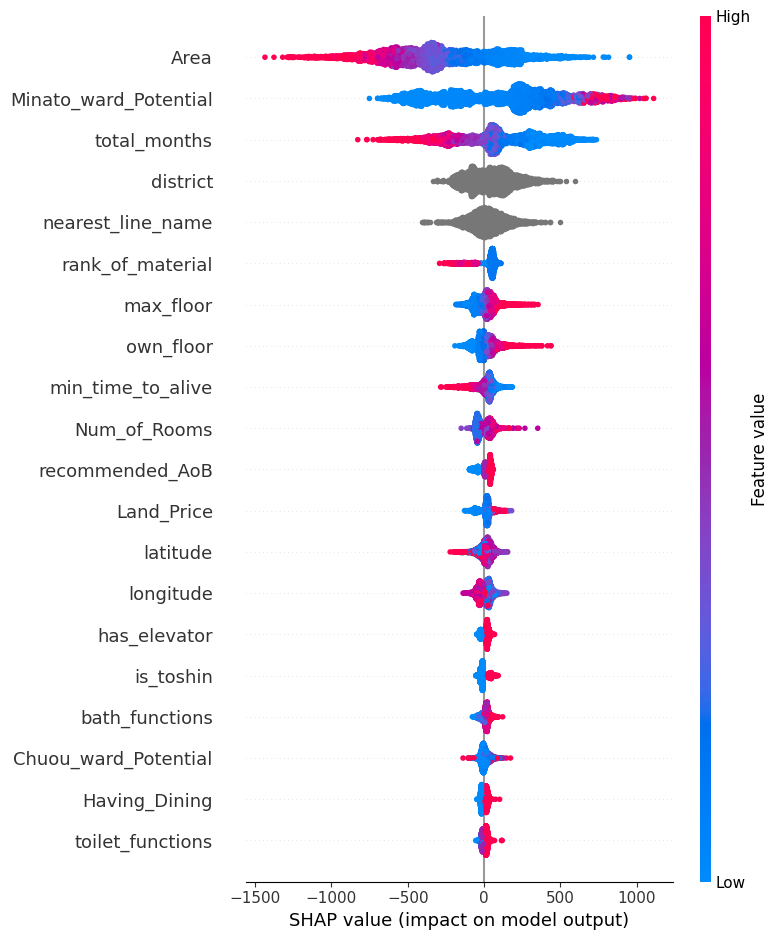

In [11]:
# SHAP値の要約プロットを作成して、モデル全体での特徴量重要度を可視化
shap.summary_plot(
   shap_values_common,                               # 計算済みのSHAP値
   X[~((X.Area >= 50) & (X.is_toshin))].iloc[:5000]  # 対応する特徴量データ（同じフィルタリング条件を適用）
)
# このプロットは：
# - 各特徴量の重要度を示す（上から下へ重要度順）
# - 特徴量の値（低い=青、高い=赤）が予測値にどう影響するかを表示
# - 特徴量の分布を点の密度で表現

In [12]:
# Plotlyを使用して特徴量重要度をインタラクティブに可視化する
import plotly.express as px  # Plotlyライブラリをインポート

# 特徴量重要度をプロットする関数を定義
def plot_feature_importance(importance, feature_names, title):
   # 特徴量名と重要度をデータフレームに格納
   feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
   # 重要度の降順でソート
   feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
   # 水平棒グラフを作成
   fig = px.bar(feature_importance, x='Importance', y='Feature', orientation='h', title=title)
   # Y軸の順序を調整（合計値の昇順で表示）
   fig.update_layout(yaxis={'categoryorder':'total ascending'})
   # グラフを表示
   fig.show()

# 最初の一般価格帯モデルから特徴量名を取得
feature_names = common_price_models[0].feature_name()
# ゲイン重要度（損失関数の改善度合いに基づく重要度）を取得
gain_importance = common_price_models[0].feature_importance(importance_type='gain')
# スプリット重要度（特徴量が使用された回数に基づく重要度）を取得
split_importance = common_price_models[0].feature_importance(importance_type='split')

# ゲイン重要度をプロット
plot_feature_importance(gain_importance, feature_names, 'Feature Importance by Gain')
# スプリット重要度をプロット
plot_feature_importance(split_importance, feature_names, 'Feature Importance by Split')

In [13]:
# 高価格帯モデルのSHAP値を計算して特徴量の重要度を分析
import shap                                 # SHAPライブラリをインポート
shap.initjs()                               # JavaScriptベースの可視化を初期化
explainer_high = shap.TreeExplainer(high_price_models[4])  # 高価格帯モデルに対するSHAP値説明器を作成
# 高価格帯モデルのSHAP値を計算（面積が50以上かつ都心のデータの先頭5000件）
shap_values_high = explainer_high(X[((X.Area >= 50) & (X.is_toshin))].iloc[:5000])

In [14]:
# 高価格帯モデルの特定データポイントに対するSHAP値のフォースプロットを表示
shap.force_plot(
   explainer_high.expected_value,                    # 高価格帯モデルの基準値（平均予測値）
   shap_values_high.values[1, :],                   # 2番目のサンプルに対するSHAP値
   X[((X.Area >= 50) & (X.is_toshin))].iloc[10, :]  # 条件に合う10番目のサンプルの特徴量データ
)
# このプロットは各特徴量が高価格帯物件の予測賃料にどのように影響しているかを可視化
# 赤い特徴量は予測値を増加させ、青い特徴量は予測値を減少させる効果を示す

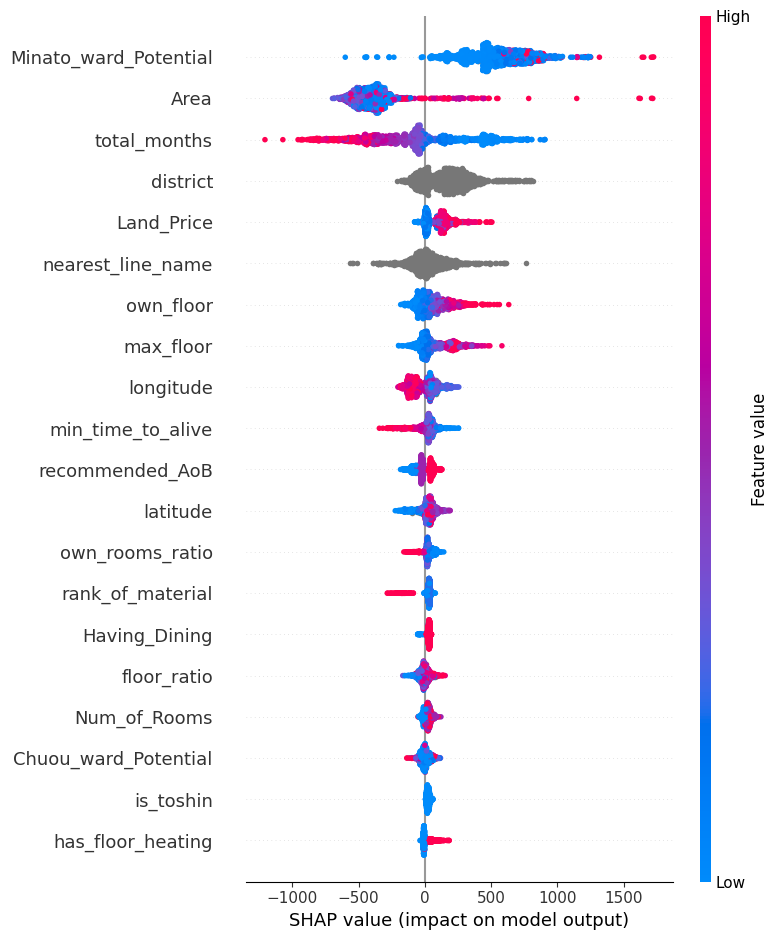

In [15]:
# 高価格帯モデルのSHAP値の要約プロットを作成して、モデル全体での特徴量重要度を可視化
shap.summary_plot(
   shap_values_high,                               # 高価格帯モデルの計算済みSHAP値
   X[((X.Area >= 50) & (X.is_toshin))].iloc[:5000]  # 対応する特徴量データ（都心・大型物件のみ）
)
# このプロットは：
# - 高価格帯物件において各特徴量の重要度を示す（上から下へ重要度順）
# - 特徴量の値（低い=青、高い=赤）が予測値にどう影響するかを表示
# - 都心の大型物件における特徴量の分布とその影響を視覚化

In [16]:
# Plotlyを使用して高価格帯モデルの特徴量重要度をインタラクティブに可視化
import plotly.express as px  # Plotlyライブラリをインポート

# 特徴量重要度をプロットする関数を定義
def plot_feature_importance(importance, feature_names, title):
    # 特徴量名と重要度をデータフレームに格納
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    # 重要度の降順でソート
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # 水平棒グラフを作成
    fig = px.bar(feature_importance, x='Importance', y='Feature', orientation='h', title=title)
    # Y軸の順序を調整（合計値の昇順で表示）
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    # グラフを表示
    fig.show()

# 最初の高価格帯モデルから特徴量名を取得
feature_names = high_price_models[0].feature_name()
# ゲイン重要度（損失関数の改善度合いに基づく重要度）を取得
gain_importance = high_price_models[0].feature_importance(importance_type='gain')
# スプリット重要度（特徴量が使用された回数に基づく重要度）を取得
split_importance = high_price_models[0].feature_importance(importance_type='split')

# ゲイン重要度をプロット（特徴量がモデルの予測精度にどれだけ貢献したかを示す）
plot_feature_importance(gain_importance, feature_names, 'Feature Importance by Gain')
# スプリット重要度をプロット（特徴量がモデル内で使用された頻度を示す）
plot_feature_importance(split_importance, feature_names, 'Feature Importance by Split')

# Making Submission File

In [17]:
# 一般価格帯モデルを使用したテストデータの予測
X_test_common = test[~((test.Area >= 50) & (test.is_toshin))]  # 一般価格帯の条件に合うテストデータを抽出
preds = []  # 予測結果を格納するリスト
for model in common_price_models:
   # テストセットに対する予測（単位面積当たり予測値 × 面積）
   preds.append(model.predict(X_test_common[X_test_common.Target.isna()].drop(['id', 'Target', 'Unit_Target'],axis=1))
                * X_test_common[X_test_common.Target.isna()].Area)
mean_preds = np.mean(preds, axis=0)  # 全モデルの平均予測値を計算
# 予測値をテストデータの目的変数列に格納
X_test_common.loc[X_test_common["Target"].isna(), "Target"] = mean_preds

# 高価格帯モデルを使用したテストデータの予測
X_test_high = test[((test.Area >= 50) & (test.is_toshin))]  # 高価格帯の条件に合うテストデータを抽出
preds = []  # 予測結果を格納するリスト
for model in high_price_models:
   # テストセットに対する予測
   preds.append(model.predict(X_test_high[X_test_high.Target.isna()].drop(['id', 'Target', 'Unit_Target'],axis=1))
               * X_test_high[X_test_high.Target.isna()].Area)
mean_preds = np.mean(preds, axis=0)  # 全モデルの平均予測値を計算
# 予測値をテストデータの目的変数列に格納
X_test_high.loc[X_test_high["Target"].isna(), "Target"] = mean_preds

# 一般価格帯と高価格帯の予測結果を結合
test_ = pd.concat([X_test_common, X_test_high], axis=0).sort_values(by='id').reset_index()
display(test_.head())  # 結合したテストデータの先頭数行を表示

# 提出用ファイルの作成
sub = pd.read_csv(SUB_PATH, header=None)  # 提出用サンプルファイルの読み込み
sub.columns = ['id', 'Target']  # 列名を設定
sub = sub.drop('Target', axis=1)  # 既存のTarget列を削除
# テストデータの予測結果と提出用データを結合（ID列に基づいて）
sub = pd.merge(sub, test_, on='id', how='left')[['id', 'Target']]

,index,id,Target,Direction,Area,district,is_toshin,latitude,longitude,Land_Price,...,super_distance,cs_distance,count_buildings,rank_of_material,is_temporal,term,is_vintage,Unit_Target,Minato_ward_Potential,Chuou_ward_Potential
0,42659,31471,139268.28778,南,50.22,世田谷,0,35.618809,139.649523,580230.000000,...,215.0,74.0,5.0,6,0,NaN,0,NaN,108.258253,49.627132
1,54305,31472,120000.00000,南東,20.88,目黒,0,35.619449,139.672940,792000.000000,...,128.0,325.0,4.0,2,0,24.0,0,5747.126437,180.905931,68.888952
2,34306,31473,75000.00000,南東,26.93,豊島,0,35.741710,139.710158,NaN,...,529.0,316.0,4.0,6,0,24.0,0,2784.998143,113.443918,106.704272
3,40447,31474,59000.00000,南東,23.57,杉並,0,35.675258,139.656947,555750.000000,...,286.0,395.0,5.0,8,0,24.0,0,2503.182011,136.329556,66.025398
4,54501,31475,90000.00000,南,50.00,杉並,0,35.688278,139.652352,530202.048417,...,902.0,312.0,9.0,2,0,24.0,0,1800.000000,112.657702,60.671745


In [18]:
# 提出用データのサイズと元のテストデータのサイズを確認
len(sub), len(pd.read_csv('dataset/test.csv'))  # 両者のサイズが一致しているか確認

(31262, 31262)

In [19]:
# 目的変数が欠損しているデータを確認
sub[sub.Target.isna()]  # 予測が正しく行われているか確認するため、欠損値があれば表示

,id,Target


In [20]:
# 最終的な提出用データフレームを確認
sub  # 提出用データフレームの内容を表示

,id,Target
0,31471,139268.287780
1,31472,120000.000000
2,31473,75000.000000
3,31474,59000.000000
4,31475,90000.000000
...,...,...
31257,62728,100884.615385
31258,62729,99250.000000
31259,62730,172000.000000
31260,62731,280000.000000


In [21]:
# 提出用ファイルの保存
sub.to_csv('submission.csv', header=False, index=False)  # ヘッダーとインデックスなしでCSVファイルに保存